In [ ]:
!pip install stanfordcorenlp
import pandas as pd
import nltk
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
import re, string
from google.colab import drive
from stanfordcorenlp import StanfordCoreNLP
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DeepLearning/dataset/Bitcoin_commnent_sentiment_50k.csv")
df.head()

,comment,created_time
0,If this goes any lower my dad is going to give...,1.621424e+09
1,$60k: OMG I WISH I WOULD HAVE BOUGHT AT $30K! ...,1.621435e+09
2,Guys Im a long time Bitcoiner from 2013. Not r...,1.621430e+09
3,This place is like a time capsule. I remember...,1.621413e+09
4,Why would you be selling for a loss when you c...,1.621402e+09


In [ ]:
#Từ điển chứa các từ viết tắt và nghĩa tương ứng
standfor = {"im" : "i am",
            "youre" : "you are",
            "hes" : "he is",
            "shes" : "she is",
            "its" : "it is",
            "were" : "we are",
            "theyre" : "they are",
            "dont" : "do not",
            "doesnt" : "does not",
            "didnt" : "did not",
            "cant" : "cannot",
            "couldnt" : "could not",
            "shouldnt" : "should not",
            "wont" : "will not",
            "wouldnt" : "would not",
            "isnt" : "is not",
            "arent" : "are not",
            "hasnt" : "has not",
            "havent" : "have not",
            "hadnt" : "had not",
            "wasnt" : "was not",
            "werent" : "were not",
            "aint" : "be not",
            "y'all": "you all",
            "cuz": "because",
            "ill": "i will",
            "hodl": "hold",
            "u": "you",
            "itll": "it will",
            "idk": "i do not know",
            "ive": "i have"}
#Hàm này thực hiện việc thay thế các từ viết tắt trong chuỗi s bằng nghĩa tương ứng trong từ điển standfor
def replace_words(s):
    #Biểu thức chính quy để tạo ra một mẫu tìm kiếm từ viết tắt trong chuỗi
    pattern = re.compile(r'\b(' + '|'.join(standfor.keys()) + r')\b')
    #Dùng phương thức sub của biểu thức chính quy để thay thế các từ viết tắt trong chuỗi s bằng giá trị tương ứng trong từ điển standfor.
    result = pattern.sub(lambda x: standfor[x.group()], s)
    return result

# Làm sạch dữ liệu
def clean_data(sentences):
    new = []
    for sen in sentences:
        # Kiểm tra nếu đầu vào là một chuỗi (string)
        if isinstance(sen, str):
            # Loại bỏ ký tự đặc biệt + chuẩn hóa chữ thường, giữ lại dấu chấm và phẩy để thư viện standford phân tích không bị lỗi
            c =  re.sub(r"[^\w\s.,]", '', sen.lower())
            c = replace_words(c)
            # i thành I
            c= re.sub(r'\bi\b', 'I', c)
            # Loại bỏ số và ký tự đi kèm theo số: vd như 30k
            c = re.sub('\w*\d\w*', '', c)
            # Loại bỏ những icon
            c = ''.join(s for s in c if s <= '\uFFFF')
            c =  c.encode('ascii', 'ignore').decode('ascii')
            # Loại bỏ các từ quá dài
            c = " ".join([w for w in c.split() if len(w) < 10])
        else:
            c = ""
        new.append(c)
    return pd.DataFrame(new, columns=["comments"])


def remove_empty_str(df):
    # Loại bỏ các hàng có giá trị na trong cột "comment"
    df = df.dropna(subset=['comment'])
    # Loại bỏ các hàng có giá trị không phải chuỗi trong cột "comment"
    df = df[df['comment'].apply(lambda x: isinstance(x, str))]
    # Thêm một cột mới vào DataFrame để đếm số từ trong mỗi comment
    df["word_count"] = df["comment"].apply(lambda x: len(x.split()))
    # Lọc ra các hàng có số lượng từ bằng 0
    empty_rows = df[df["word_count"] == 0].index
    # Xóa các hàng đó khỏi dataframe
    df.drop(empty_rows, inplace=True)
    # Xóa cột word_count
    df.drop("word_count", axis=1, inplace=True)
    return df
df["comment"]= clean_data(df["comment"])
remove_empty_str(df)
print(len(df))

49557


In [ ]:
df

,comment,created_time
0,if this goes any lower my dad is going to give...,1.621424e+09
1,omg I wish I would have bought at omg it is over,1.621435e+09
2,guys I am a long time bitcoiner from . not ric...,1.621430e+09
3,this place is like a time capsule. I remember ...,1.621413e+09
4,why would you be selling for a loss when you c...,1.621402e+09
...,...,...
49552,"it is . new york time, . on the west coast so ...",1.522414e+09
49553,what is the between paying and for something t...,1.522432e+09
49554,not not much new money left. any retail ie hol...,1.522435e+09
49555,yes but do not know when,1.522434e+09


## Trích xuất khía cạnh và các từ chỉ tình cảm

In [ ]:
from stanfordcorenlp import StanfordCoreNLP
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

# Khởi tạo đối tượng StanfordCoreNLP với địa chỉ URL của máy chủ
nlp = StanfordCoreNLP("/content/drive/MyDrive/DeepLearning/pretrained/stanford-corenlp-4.5.5")

# Hàm trả về cú pháp phụ thuộc
def get_dep(dependencies, idx):
    # Tìm tất cả các phụ thuộc cú pháp của từ có index = idx
    for dep in dependencies:
        if dep[2] == (idx + 1):
            return dep
    return None

# Định nghĩa một hàm để trích xuất các khía cạnh sử dụng luật dựa trên cấu trúc cú pháp

def extract_aspects(df):
    post_arr = []
    depp_arr = []
    aspect_arr = []
    aspect_arr_position_in_sentences = []
    new_cmts_arr = []
    created_time = []
    # Lặp qua từng comment
    for index in range(len(df)):
        if(index%1000==0):
          print(index/len(df))
        comment = df['comment'][index]
        # Sử dụng nltk để tách thành các câu
        sens = sent_tokenize(comment)
        last_word_commented_pos = 0
        for sen in sens:
            # Chia câu ra từng từ
            tokens = word_tokenize(sen)
            pos = pos_tag(tokens) # Phân loại pos tag cho các từ, pos tag là các loại từ như danh từ, tính từ, động từ, ...
            dep = nlp.dependency_parse(sen) # Phân tích cú pháp phụ thuộc của câu
            for i in range(len(tokens)):
                if len(tokens) != len(dep): # Những comments này bị lỗi phân tích cú pháp, bỏ qua
                    #print("Sai")
                    break
                # Trích xuất khía cạnh, kiểm tra từ có phải là danh tư không bằng pos tag.
                if pos[i][1].startswith("N") and tokens[i] != "i":
                    try:
                        # Luật 1: Nếu một từ là danh từ đứng sau một danh từ khác thì kết nối từ đó với danh từ đứng trước. Từ ghép này là một khía cạnh.
                        if i > 0 and pos[i - 1][1].startswith("N"):
                            aspect_arr.append(tokens[i - 1] + " " + tokens[i])
                            aspect_arr_position_in_sentences.append(i-0.5+last_word_commented_pos)
                            new_cmts_arr.append(comment)
                            post_arr.append(pos)
                            depp_arr.append(dep)
                            created_time.append(df['created_time'][index])
                        # Luật 2: Nếu một từ là một danh từ và nó có quan hệ vị ngữ “obj” với một động từ trong câu thì danh từ đó là một khía cạnh.
                        # get_dep(dep, i) hàm trả về cú pháp phụ thuộc của danh từ và xem từ phụ thuộc đó có phải là động từ hay không?
                        elif get_dep(dep, i)[0] == "obj" and pos[get_dep(dep, i)[1] - 1][1].startswith("V"):
                            aspect_arr.append(tokens[i])
                            aspect_arr_position_in_sentences.append(i+last_word_commented_pos)
                            new_cmts_arr.append(comment)
                            post_arr.append(pos)
                            depp_arr.append(dep)
                            created_time.append(df['created_time'][index])
                        # Luật 3: Nếu một từ là danh từ và nó có quan hệ chủ ngữ “nsubj” với một tính từ trong câu thì từ đó là một khía cạnh.
                        # get_dep(dep, i) hàm trả về cú pháp phụ thuộc của danh từ và xem từ phụ thuộc đó có phải là tính từ hay không?
                        elif get_dep(dep, i)[0] == "nsubj" and pos[get_dep(dep, i)[1] - 1][1].startswith("J"):
                            aspect_arr.append(tokens[i])
                            aspect_arr_position_in_sentences.append(i+last_word_commented_pos)
                            new_cmts_arr.append(comment)
                            post_arr.append(pos)
                            depp_arr.append(dep)
                            created_time.append(df['created_time'][index])
                        # Luật 4: Nếu một từ là danh từ và có mối quan hệ bổ nghĩa "nmod" với một động từ trong câu thì từ đó là một khía cạnh.
                        # get_dep(dep, i) hàm trả về cú pháp phụ thuộc của danh từ và xem từ phụ thuộc đó có phải là động từ hay không?
                        elif get_dep(dep, i)[0] == "nmod" and pos[get_dep(dep, i)[1] - 1][1].startswith("V"):
                            aspect_arr.append(tokens[i])
                            aspect_arr_position_in_sentences.append(i+last_word_commented_pos)
                            new_cmts_arr.append(comment)
                            post_arr.append(pos)
                            depp_arr.append(dep)
                            created_time.append(df['created_time'][index])
                    except Exception as e:
                      # stanfordcorenlp.dependency_parse biểu diển quan hệ của tất cả các từ và các cụm từ.
                      # pos không phân tích các cụm từ đó nên lổi index
                       #print("depp:", len(dep), "- pos: ", len(pos))
                       #print("depp:", dep, "- pos: ", pos)
                       #print("Cau:", sen + "\n")
                       last_word_commented_pos = last_word_commented_pos+len(tokens)
                       break
            last_word_commented_pos = last_word_commented_pos+len(tokens)
    return pd.DataFrame({"comment": new_cmts_arr, "aspects": aspect_arr, "aspects_position":aspect_arr_position_in_sentences, "pos_tags": post_arr, "depencies": depp_arr, "created_time":created_time})

#Tìm các từ mô tả cảm xúc bằng cách tìm tất cả các tính từ có trong df['comment']
def find_words_feeling(df):
    words_feeling = []
    for index in range(len(df)):
        sen = df['comment'][index]
        # Loại bỏ các dấu chấm trong chuỗi bằng cách thay thế chúng bằng chuỗi rỗng
        sen = re.sub(r'\.', '', sen)
        # Chia câu ra từng từ
        tokens = word_tokenize(sen)
        pos = pos_tag(tokens)# Phân loại pos tag cho các từ, pos tag là các loại từ như danh từ, tính từ, động từ, ...
        #Tìm các tính từ chỉ tình cảm
        for i in range(len(tokens)):
            if pos[i][1].startswith("J"):# and tokens[i] != "i":
              if[pos[i][0]] not in words_feeling:
                  words_feeling = words_feeling + [pos[i][0]]
    return words_feeling


In [ ]:
df

,comment,created_time
0,if this goes any lower my dad is going to give...,1.621424e+09
1,omg I wish I would have bought at omg it is over,1.621435e+09
2,guys I am a long time bitcoiner from . not ric...,1.621430e+09
3,this place is like a time capsule. I remember ...,1.621413e+09
4,why would you be selling for a loss when you c...,1.621402e+09
...,...,...
49552,"it is . new york time, . on the west coast so ...",1.522414e+09
49553,what is the between paying and for something t...,1.522432e+09
49554,not not much new money left. any retail ie hol...,1.522435e+09
49555,yes but do not know when,1.522434e+09


In [ ]:
comments_with_aspect = extract_aspects(df)
words_feeling = find_words_feeling(df)
comments_with_aspect.head()

0.0
0.020178784026474564
0.04035756805294913
0.06053635207942369
0.08071513610589826
0.10089392013237282
0.12107270415884738
0.14125148818532196
0.1614302722117965
0.1816090562382711
0.20178784026474564
0.22196662429122022
0.24214540831769477
0.2623241923441693
0.2825029763706439
0.30268176039711847
0.322860544423593
0.3430393284500676
0.3632181124765422
0.3833968965030167
0.4035756805294913
0.4237544645559659
0.44393324858244043
0.464112032608915
0.48429081663538953
0.5044696006618641
0.5246483846883386
0.5448271687148133
0.5650059527412878
0.5851847367677624
0.6053635207942369
0.6255423048207115
0.645721088847186
0.6658998728736606
0.6860786569001353
0.7062574409266098
0.7264362249530844
0.7466150089795589
0.7667937930060335
0.786972577032508
0.8071513610589826
0.8273301450854571
0.8475089291119318
0.8676877131384063
0.8878664971648809
0.9080452811913554
0.92822406521783
0.9484028492443045
0.9685816332707791
0.9887604172972536


,comment,aspects,aspects_position,pos_tags,depencies,created_time
0,if this goes any lower my dad is going to give...,belt,13.0,"[(if, IN), (this, DT), (goes, VBZ), (any, DT),...","[(ROOT, 0, 3), (mark, 3, 1), (nsubj, 3, 2), (d...",1.621424e+09
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,5.5,"[(guys, NNS), (I, PRP), (am, VBP), (a, DT), (l...","[(ROOT, 0, 7), (nsubj, 7, 1), (nsubj, 7, 2), (...",1.621430e+09
2,guys I am a long time bitcoiner from . not ric...,lot,15.0,"[(not, RB), (rich, JJ), (,, ,), (but, CC), (pu...","[(ROOT, 0, 2), (advmod, 2, 1), (punct, 2, 3), ...",1.621430e+09
3,guys I am a long time bitcoiner from . not ric...,money,49.0,"[(only, RB), (one, CD), (thing, NN), (pisses, ...","[(ROOT, 0, 4), (advmod, 2, 1), (nummod, 3, 2),...",1.621430e+09
4,this place is like a time capsule. I remember ...,time capsule,5.5,"[(this, DT), (place, NN), (is, VBZ), (like, IN...","[(ROOT, 0, 7), (det, 2, 1), (nsubj, 7, 2), (co...",1.621413e+09


In [ ]:
print(comments_with_aspect["comment"])

0        if this goes any lower my dad is going to give...
1        guys I am a long time bitcoiner from . not ric...
2        guys I am a long time bitcoiner from . not ric...
3        guys I am a long time bitcoiner from . not ric...
4        this place is like a time capsule. I remember ...
                               ...                        
60711    not not much new money left. any retail ie hol...
60712    not not much new money left. any retail ie hol...
60713    not not much new money left. any retail ie hol...
60714    not not much new money left. any retail ie hol...
60715                        slow and steady wins the race
Name: comment, Length: 60716, dtype: object


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

#comments_with_aspect = pd.read_csv("/content/drive/MyDrive/DeepLearning/dataset/commnents_with_aspect.csv")

a = comments_with_aspect["aspects"].values


# Đếm số lần xuất hiện của các phần tử trong mảng
counts = Counter(a)

# Sắp xếp từ điển theo giá trị (counts) theo thứ tự giảm dần
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

for i, (k, v) in enumerate(sorted_counts.items()):
    if i >= 20:
        break
    print(k, " : ", v)


bitcoin  :  2076
dip  :  1042
btc  :  969
money  :  912
price  :  682
people  :  416
time  :  356
sats  :  315
coins  :  284
lot  :  253
way  :  247
coin  :  244
something  :  244
dips  :  237
market  :  231
bull run  :  223
shit  :  218
anything  :  210
amount  :  204
thing  :  202


### Gắn điểm từ -1 đến 1 cho các từ chỉ tình cảm. Trong đó bé hơn 0 là tiêu cực, 0 là trung lập và lớn hơn 0 là tích cực.

In [ ]:
import textblob
# Chuyển đổi mảng thành bộ
word_score = {}
for word in words_feeling:
  blob = textblob.TextBlob(word)
  word_score[word] = blob.polarity
print(len(word_score))
print(word_score)
print(word_score.keys())

4949
{'lower': 0.0, 'long': -0.05, 'rich': 0.375, 'spare': 0.0, 'more': 0.5, 'exact': 0.25, 'same': 0.0, 'fud': 0.0, 'different': 0.0, 'latest': 0.5, 'sorry': -0.5, 'btc': 0.0, 'last': 0.0, 'afraid': -0.6, 'good': 0.7, 'sorta': 0.0, 'erratic': 0.0, 'stupid': -0.7999999999999999, 'complete': 0.1, 'bigger': 0.0, 'normal': 0.15, 'aware': 0.25, 'many': 0.5, 'mental': -0.1, 'uninstall': 0.0, 'best': 1.0, 'happiness': 0.7, 'whole': 0.2, 'old': 0.1, 'much': 0.2, 'comical': 0.5, 'bs': 0.0, 'cliche': 0.0, 'scary': -0.5, 'first': 0.25, 'initial': 0.0, 'november': 0.0, 'absolute': 0.2, 'stronger': 0.0, 'little': -0.1875, 'negative': -0.3, 'bad': -0.6999999999999998, 'obvious': 0.0, 'like': 0.0, 'new': 0.13636363636363635, 'safer': 0.0, 'less': -0.16666666666666666, 'other': -0.125, 'late': -0.3, 'wish': 0.0, 'luck': 0.0, 'coming': 0.0, 'most': 0.5, 'massive': 0.0, 'huge': 0.4000000000000001, 'fat': 0.0, 'fearful': -0.9, 'greedy': 0.0, 'warren': 0.0, 'youve': 0.0, 'biggest': 0.0, 'daily': 0.0, 'de

## Xác định tình cảm theo khía cạnh bằng phương pháp từ vựng

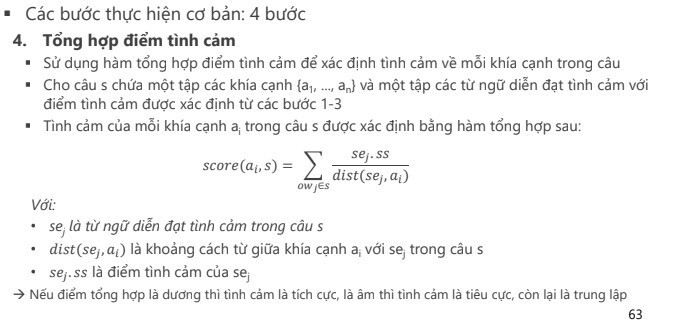

In [ ]:
import numpy as np
import math
# Hàm này thực hiện phân tích cảm xúc trong câu dựa trên từ điển các từ chỉ cảm xúc
def sentiment_analysis(sentence, aspects, aspects_position):
    score = 0
    words = word_tokenize(sentence)
    # Duyệt qua từng từ trong câu
    for index, word in enumerate(words):
       # Nếu từ có trong từ điển chỉ cảm xúc
      if(word in word_score.keys()):
        # Tính điểm số cảm xúc dựa trên điểm của từ chỉ cảm xúc và vị trí tương đối của từ so với các khía cạnh (aspects) trong câu
        score = score + word_score[word]/(math.floor(abs(aspects_position-index))+0.001)
    return score

#test sentiment_analysis
g = 28
cmt = comments_with_aspect["comment"].values[g]
aspect = comments_with_aspect["aspects"].values[g]
aspects_position = comments_with_aspect["aspects_position"].values[g]
print("Câu full:", cmt)
print("Khía cạnh:", aspect)
print(sentiment_analysis(cmt, aspect, aspects_position))


Câu full: usually I am here laughing at the dips and cracking jokes but this is a bigger dip than normal and I am aware many of you may have lost a lot of money. do not neglect your mental health today. close the charts, take a walk. reach out for help if you need. look after
Khía cạnh: jokes
0.07446653299407721


In [ ]:
#Xác định tình cảm theo khía cạnh bằng hàm sentiment_analysis
predict_feeling_aspects_comments = []
for index in range(len(comments_with_aspect)):
  cmt = comments_with_aspect["comment"][index]
  aspect = comments_with_aspect["aspects"][index]
  aspects_position = comments_with_aspect["aspects_position"][index]
  score = sentiment_analysis(cmt, aspect, aspects_position)
  if score > 0:
    predict_feeling_aspects_comments.append("POSITIVE")
  elif score == 0:
    predict_feeling_aspects_comments.append("NEUTRAL")
  else:
    predict_feeling_aspects_comments.append("NEGATIVE")
comments_with_aspect['label'] = predict_feeling_aspects_comments

In [ ]:
comments_with_aspect

,comment,aspects,aspects_position,pos_tags,depencies,created_time,label
0,if this goes any lower my dad is going to give...,belt,13.0,"[(if, IN), (this, DT), (goes, VBZ), (any, DT),...","[(ROOT, 0, 3), (mark, 3, 1), (nsubj, 3, 2), (d...",1.621424e+09,NEUTRAL
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,5.5,"[(guys, NNS), (I, PRP), (am, VBP), (a, DT), (l...","[(ROOT, 0, 7), (nsubj, 7, 1), (nsubj, 7, 2), (...",1.621430e+09,POSITIVE
2,guys I am a long time bitcoiner from . not ric...,lot,15.0,"[(not, RB), (rich, JJ), (,, ,), (but, CC), (pu...","[(ROOT, 0, 2), (advmod, 2, 1), (punct, 2, 3), ...",1.621430e+09,POSITIVE
3,guys I am a long time bitcoiner from . not ric...,money,49.0,"[(only, RB), (one, CD), (thing, NN), (pisses, ...","[(ROOT, 0, 4), (advmod, 2, 1), (nummod, 3, 2),...",1.621430e+09,POSITIVE
4,this place is like a time capsule. I remember ...,time capsule,5.5,"[(this, DT), (place, NN), (is, VBZ), (like, IN...","[(ROOT, 0, 7), (det, 2, 1), (nsubj, 7, 2), (co...",1.621413e+09,POSITIVE
...,...,...,...,...,...,...,...
60711,not not much new money left. any retail ie hol...,bots,30.0,"[(seems, VBZ), (most, JJS), (volume, NN), (now...","[(ROOT, 0, 6), (aux, 6, 1), (advmod, 3, 2), (n...",1.522435e+09,POSITIVE
60712,not not much new money left. any retail ie hol...,public,35.0,"[(now, RB), (the, DT), (general, JJ), (public,...","[(ROOT, 0, 7), (advmod, 7, 1), (det, 4, 2), (a...",1.522435e+09,POSITIVE
60713,not not much new money left. any retail ie hol...,way bitcoin,57.5,"[(the, DT), (only, JJ), (way, NN), (we, PRP), ...","[(ROOT, 0, 6), (det, 3, 1), (amod, 3, 2), (nsu...",1.522435e+09,NEGATIVE
60714,not not much new money left. any retail ie hol...,bitcoin,82.0,"[(and, CC), (I, PRP), (am, VBP), (afraid, JJ),...","[(ROOT, 0, 5), (cc, 5, 1), (nsubj, 5, 2), (cop...",1.522435e+09,POSITIVE


In [ ]:
df_selected = comments_with_aspect.loc[:, ["comment", "aspects",'label', 'aspects_position', 'created_time']]

In [ ]:
df_selected
df_selected.to_csv("dataset50k_have_label.csv", index=False)

## Trả lời các câu hỏi nghiên cứu

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.tag import pos_tag
# Tải dữ liệu từ điển cần thiết
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/DeepLearning/dataset/dataset50k_have_label.csv")

In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/DeepLearning/dataset/GiaBitcoin.csv")

In [ ]:
df2.head()

,comment,aspects,label,aspects_position,created_time
0,if this goes any lower my dad is going to give...,belt,NEUTRAL,13.0,1.621424e+09
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,POSITIVE,5.5,1.621430e+09
2,guys I am a long time bitcoiner from . not ric...,lot,POSITIVE,15.0,1.621430e+09
3,guys I am a long time bitcoiner from . not ric...,money,POSITIVE,49.0,1.621430e+09
4,this place is like a time capsule. I remember ...,time capsule,POSITIVE,5.5,1.621413e+09


In [ ]:
df3.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,06/01/2024,"43,721.6","44,156.6","44,203.2","43,424.0",47.20K,-0.99%
1,05/01/2024,"44,156.9","44,163.0","44,312.1","42,629.0",68.07K,0.00%
2,04/01/2024,"44,157.0","42,836.1","44,744.5","42,632.8",68.05K,3.08%
3,03/01/2024,"42,836.1","44,943.7","45,492.7","40,888.3",117.65K,-4.69%
4,02/01/2024,"44,943.7","44,182.9","45,885.4","44,166.0",97.84K,1.72%


In [ ]:
# Chuyển đổi cột ngày về định dạng datetime, đặt errors='coerce' để chuyển đổi sai thành NaT (Not a Time)
df3['Ngày'] = pd.to_datetime(df3['Ngày'], errors='coerce')
# Loại bỏ các dòng có giá trị Ngày không phải là ngày tháng năm
df3 = df3.dropna(subset=['Ngày'])
# Xóa dấu phẩy và chuyển đổi thành số (float)
df3['Lần cuối'] = df3['Lần cuối'].apply(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
# Loại bỏ các dòng có giá trị không phải là float trong cột "Lần cuối"
df3 = df3[df3['Lần cuối'].notnull()]
# Chuyển đổi 'Ngày' sang định dạng thời gian Tháng
df3['year_month'] = pd.to_datetime(df3['Ngày']).dt.to_period('M')

<ipython-input-21-40324dadad05>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df3['Ngày'] = pd.to_datetime(df3['Ngày'], errors='coerce')


In [ ]:
df3.groupby(["year_month"])["Lần cuối"].mean().reset_index()

,year_month,Lần cuối
0,2010-01,0.14
1,2010-02,0.16
2,2010-03,0.16
3,2010-04,0.14
4,2010-05,0.16
...,...,...
169,2024-02,44943.70
170,2024-03,42836.10
171,2024-04,44157.00
172,2024-05,44156.90


In [ ]:
# Chuyển đổi cột 'created_time' sang định dạng thời gian
df2['created_time'] = pd.to_datetime(df2['created_time'], unit='s')  # Sử dụng 'unit' tùy thuộc vào đơn vị của timestamp

# Tạo cột mới 'year_month' để phân loại theo tháng
df2['year_month'] = df2['created_time'].dt.to_period('M')

In [ ]:
df2.head()

,comment,aspects,label,aspects_position,created_time,year_month
0,if this goes any lower my dad is going to give...,belt,NEUTRAL,13.0,2021-05-19 11:30:04,2021-05
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,POSITIVE,5.5,2021-05-19 13:07:49,2021-05
2,guys I am a long time bitcoiner from . not ric...,lot,POSITIVE,15.0,2021-05-19 13:07:49,2021-05
3,guys I am a long time bitcoiner from . not ric...,money,POSITIVE,49.0,2021-05-19 13:07:49,2021-05
4,this place is like a time capsule. I remember ...,time capsule,POSITIVE,5.5,2021-05-19 08:29:54,2021-05


### Câu hỏi nghiên cứu 1: Thái độ của nhà đầu tư về thị trường Bitcoin theo thời gian?

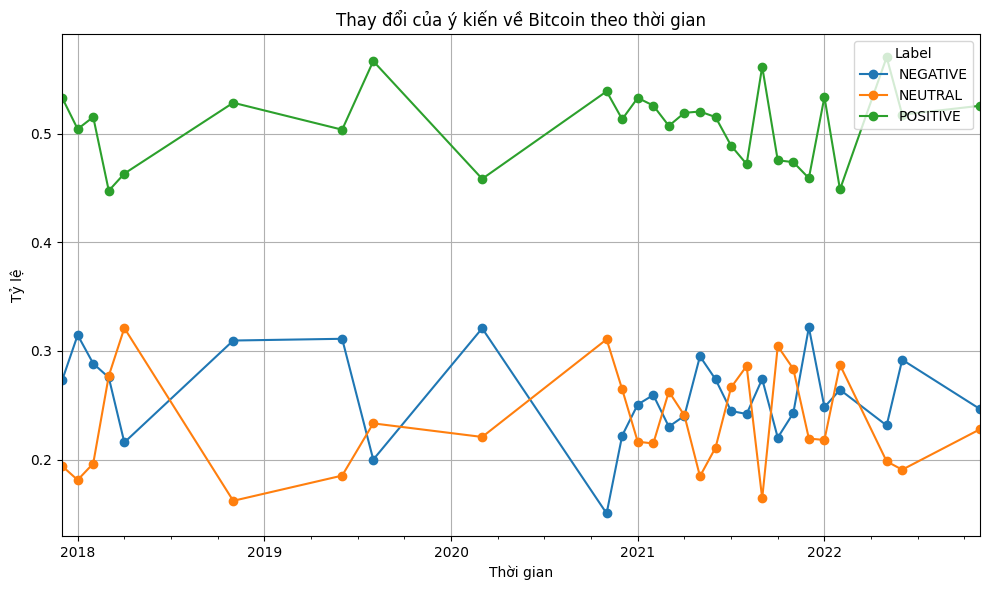

In [ ]:
# Tính tỷ lệ các nhãn 'label' theo từng tháng
label_counts = df2.groupby('year_month')['label'].value_counts(normalize=True).unstack().fillna(0)

# Biểu đồ line chart hiển thị thay đổi của các nhãn 'label' qua thời gian
label_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Thay đổi của ý kiến về Bitcoin theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Tỷ lệ')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


Nhìn chung, mọi người thường có cảm nhận tích cực về Bitcoin

Khi % tiêu cực giảm thì % trung lập có xu hướng tăng. Khi % tiêu cực tăng thì % trung lập có xu hướng giảm.

% tiêu cực, % trung lập có xu hướng chiếm lĩnh nhau

Câu hỏi nghiên cứu 2: Mối liên hệ giữa tình cảm của nhà đầu tư với biến động giá Bitcoin theo thời gian?

In [ ]:
# Tính giá trị trung bình của cột "Lần cuối" theo từng year_month trong df3
df3_mean  = df3.groupby(["year_month"])["Lần cuối"].mean().reset_index()
# Tính tỷ lệ các nhãn 'label' theo từng tháng
df2_label_counts = df2.groupby('year_month')['label'].value_counts(normalize=True).unstack().fillna(0)
# Ghép DataFrame theo cột thời gian
merged_df = pd.merge(df3_mean, df2_label_counts, left_on='year_month', right_on='year_month', how='inner')

In [ ]:
def Analyst_1x_2y(df, col1s, col2s, figsize):
  # Vẽ biểu đồ cột
  fig, ax1 = plt.subplots(figsize=figsize)
  index = df.index
  for element in col1s:
    ax1.plot(index, df[element], marker='o', label=element)
  ax1.set_xlabel('Year Month')
  ax1.set_ylabel('Sentiments')
  ax1.set_title('Sentiments and Prices')
  ax1.set_xticks(index)
  ax1.set_xticklabels(df['year_month'])
  ax1.legend()

  # Tạo trục y thứ hai
  ax2 = ax1.twinx()
  for element in col2s:
    ax2.plot(index, df[element], color='red', marker='o', label='Price')
  ax2.set_ylabel('Price')
  ax2.legend(loc='upper left')

  plt.tight_layout()
  plt.grid(True)
  plt.show()


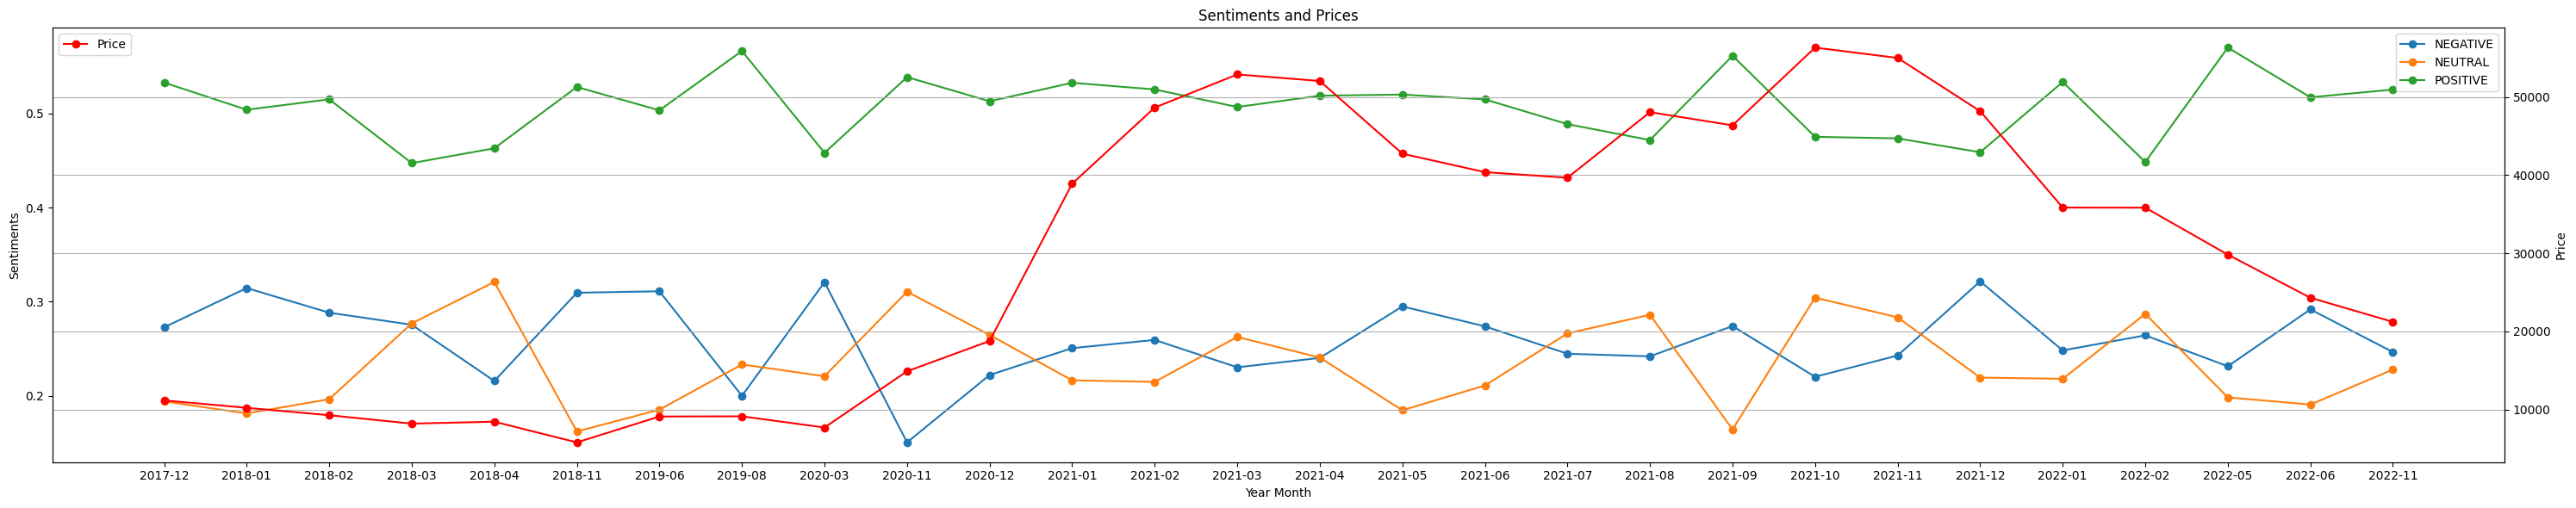

In [ ]:
Analyst_1x_2y(merged_df, ["NEGATIVE","NEUTRAL","POSITIVE"], ['Lần cuối'], (30, 6))

Nhìn vào biều đồ ta thường thấy:

Thái độ về Bitcoin có mối liên hệ chặt chẽ với giá của nó theo thời gian

Khi giá Bitcoin tăng lên thì % tiêu cực có xu hướng giảm. Khi giá Bitcoin giảm thì  % tiêu cực có xu hướng tăng.


### Câu hỏi nghiên cứu 3:
Những từ nào được sử dụng để thể hiện cảm xúc tích cực về Bitcoin?

Những từ nào được sử dụng để thể hiện cảm xúc tiêu cực về Bitcoin?


Top 10 từ trong nhãn 'POSITIVE':
more: 6648
good: 4178
new: 3527
many: 2973
much: 2757
last: 2570
long: 2553
other: 2545
same: 2045
first: 2024


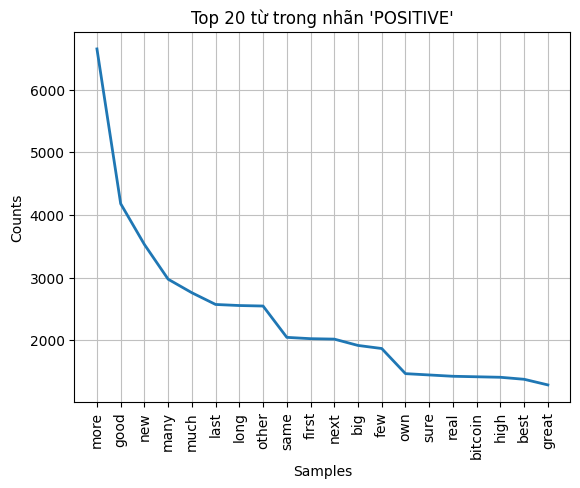

In [ ]:
# Xem xét từ hoặc cụm từ xuất hiện nhiều trong mỗi loại nhãn
sentiment_label = "POSITIVE"
comments = df2[df2['label'] == sentiment_label]['comment']
words = ' '.join(comments).lower()  # Kết hợp tất cả các comment vào một chuỗi
tokens = word_tokenize(words)  # Tokenize chuỗi thành các từ
tagged_words = pos_tag(tokens)  # Gắn nhãn loại từ cho từng từ trong câu
adjectives = [word for word, pos in tagged_words if 'JJ' in pos and word != "i"]  # Lọc ra các từ loại là tính từ (JJ)
fdist = FreqDist(adjectives)  # Tính toán tần suất xuất hiện của các từ
top_words = fdist.most_common(10)  # Lấy 10 từ xuất hiện nhiều nhất

# In ra các từ xuất hiện nhiều nhất trong mỗi nhãn label
print(f"\nTop 10 từ trong nhãn '{sentiment_label}':")
for word, frequency in top_words:
    print(f"{word}: {frequency}")
# Trực quan hóa tần suất xuất hiện của các từ
fdist.plot(20, title=f"Top 20 từ trong nhãn '{sentiment_label}'", cumulative=False)
plt.show()



Top 10 từ trong nhãn 'NEGATIVE':
other: 1524
few: 1436
long: 1376
more: 1264
last: 1156
big: 1026
new: 1011
next: 998
same: 900
bad: 880


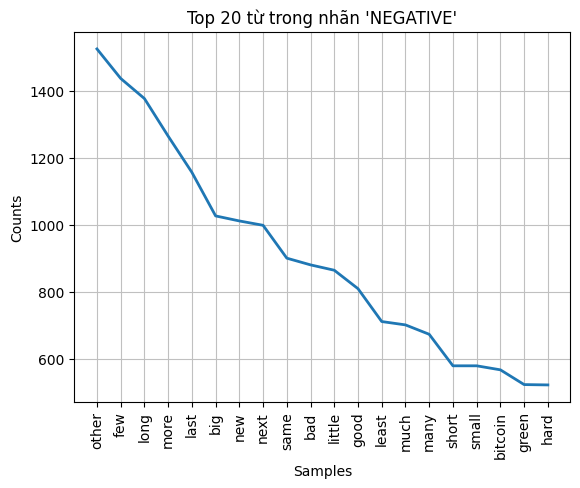

In [ ]:
# Xem xét từ hoặc cụm từ xuất hiện nhiều trong mỗi loại nhãn
sentiment_label = "NEGATIVE"
comments = df2[df2['label'] == sentiment_label]['comment']
words = ' '.join(comments).lower()  # Kết hợp tất cả các comment vào một chuỗi
tokens = word_tokenize(words)  # Tokenize chuỗi thành các từ
tagged_words = pos_tag(tokens)  # Gắn nhãn loại từ cho từng từ trong câu
adjectives = [word for word, pos in tagged_words if 'JJ' in pos and word != "i"]  # Lọc ra các từ loại là tính từ (JJ)
fdist = FreqDist(adjectives)  # Tính toán tần suất xuất hiện của các từ
top_words = fdist.most_common(10)  # Lấy 10 từ xuất hiện nhiều nhất

# In ra các từ xuất hiện nhiều nhất trong mỗi nhãn label
print(f"\nTop 10 từ trong nhãn '{sentiment_label}':")
for word, frequency in top_words:
    print(f"{word}: {frequency}")
# Trực quan hóa tần suất xuất hiện của các từ
fdist.plot(20, title=f"Top 20 từ trong nhãn '{sentiment_label}'", cumulative=False)
plt.show()

###Câu hỏi nghiên cứu 4:
Các aspects nào được liên kết nhiều nhất với các ý kiến tích cực?

Các aspects nào được liên kết nhiều nhất với các ý kiến tiêu cực?

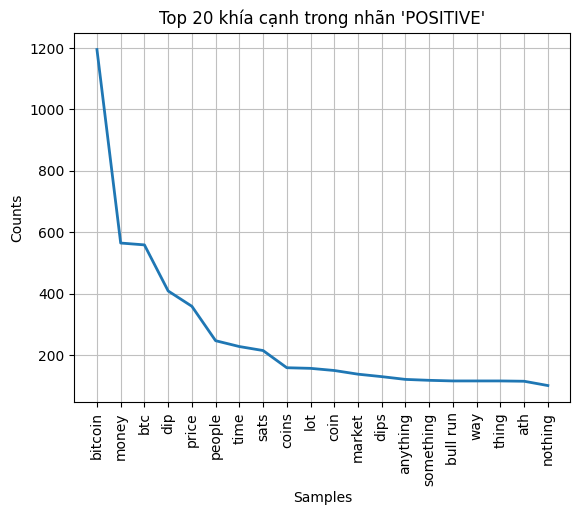


Top 40 khía cạnh trong nhãn 'POSITIVE':
bitcoin: 1195
money: 565
btc: 559
dip: 409
price: 359
people: 247
time: 228
sats: 215
coins: 159
lot: 157
coin: 150
market: 138
dips: 130
anything: 121
something: 118
bull run: 116
way: 116
thing: 116
ath: 115
nothing: 101
amount: 100
crypto: 99
bitcoins: 94
value: 87
stock market: 86
things: 78
worth: 75
cash: 73
wallet: 73
everyone: 70
market cap: 67
bit: 64
news: 61
profit: 60
guys: 60
bull market: 59
ride: 59
sense: 58
profits: 58
life: 57


In [ ]:
# In ra sự phân phối của các nhãn 'label'
sentiment_label = 'POSITIVE'
comments = df2[df2['label'] == sentiment_label]['aspects']
fdist = FreqDist(comments)  # Tính toán tần suất xuất hiện của các từ
top_words = fdist.most_common(40)  # Lấy 10 từ xuất hiện nhiều nhất

# Trực quan hóa tần suất xuất hiện của các từ
fdist.plot(20, title=f"Top 20 khía cạnh trong nhãn '{sentiment_label}'", cumulative=False)
plt.show()

# In ra các từ xuất hiện nhiều nhất trong mỗi nhãn label
print(f"\nTop 40 khía cạnh trong nhãn '{sentiment_label}':")
for word, frequency in top_words:
    print(f"{word}: {frequency}")

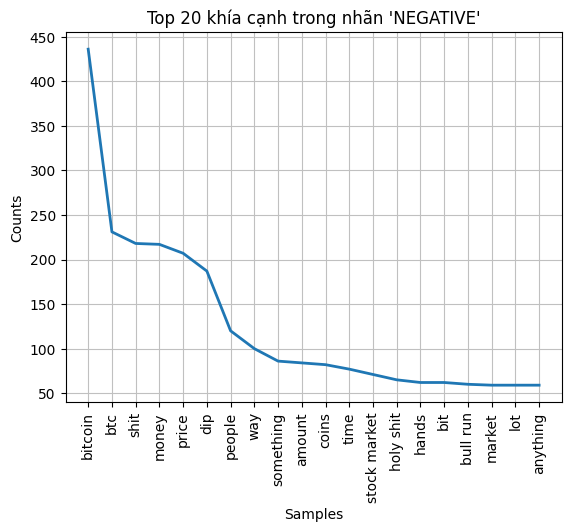


Top 40 khía cạnh trong nhãn 'NEGATIVE':
bitcoin: 436
btc: 231
shit: 218
money: 217
price: 207
dip: 187
people: 120
way: 100
something: 86
amount: 84
coins: 82
time: 77
stock market: 71
holy shit: 65
hands: 62
bit: 62
bull run: 60
market: 59
lot: 59
anything: 59
dips: 56
fuck: 53
thing: 49
sats: 48
crypto: 47
term: 47
value: 45
everyone: 44
others: 41
wallet: 40
nothing: 40
coin: 39
price action: 39
things: 37
fud: 37
wall: 33
elon musk: 32
cash: 31
guys: 30
bull market: 29


In [ ]:
# In ra sự phân phối của các nhãn 'label'
sentiment_label = 'NEGATIVE'
comments = df2[df2['label'] == sentiment_label]['aspects']
fdist = FreqDist(comments)  # Tính toán tần suất xuất hiện của các từ
top_words = fdist.most_common(40)  # Lấy 10 từ xuất hiện nhiều nhất

# Trực quan hóa tần suất xuất hiện của các từ
fdist.plot(20, title=f"Top 20 khía cạnh trong nhãn '{sentiment_label}'", cumulative=False)
plt.show()

# In ra các từ xuất hiện nhiều nhất trong mỗi nhãn label
print(f"\nTop 40 khía cạnh trong nhãn '{sentiment_label}':")
for word, frequency in top_words:
    print(f"{word}: {frequency}")

### Câu hỏi nghiên cứu 5: Thái dộ về Bitcoin theo từng khía cạnh phổ biến từ năm 2021 tới 2025?

In [ ]:
def Analyst(df, col2, col3):
    #Sao chép dữ liệu:
    temp = df
    plt.rcParams['figure.figsize'] = (18, 8)
    #Nhóm dữ liệu theo cột col1 và col2, sau đó tính giá trị trung bình của cột col3 trong mỗi nhóm.
    #Điền giá trị 0 vào những ô dữ liệu trống
    df_Analyst = pd.DataFrame(temp.groupby([col2])[col3].value_counts(normalize=True).unstack(fill_value=0))
    df_Analyst.plot.bar()
    plt.title(col2+' vs '+col3)
    plt.show()

In [ ]:
fdist = FreqDist(df2['aspects'])  # Tính toán tần suất xuất hiện của các khía cạnh
top_words = []
for word, frequency in  fdist.most_common(20):
    top_words = top_words + [word]

In [ ]:
dftem = df2[df2["aspects"].isin(top_words)]
dftem = dftem[dftem['created_time'].between('2019-01-01', '2022-12-31')]

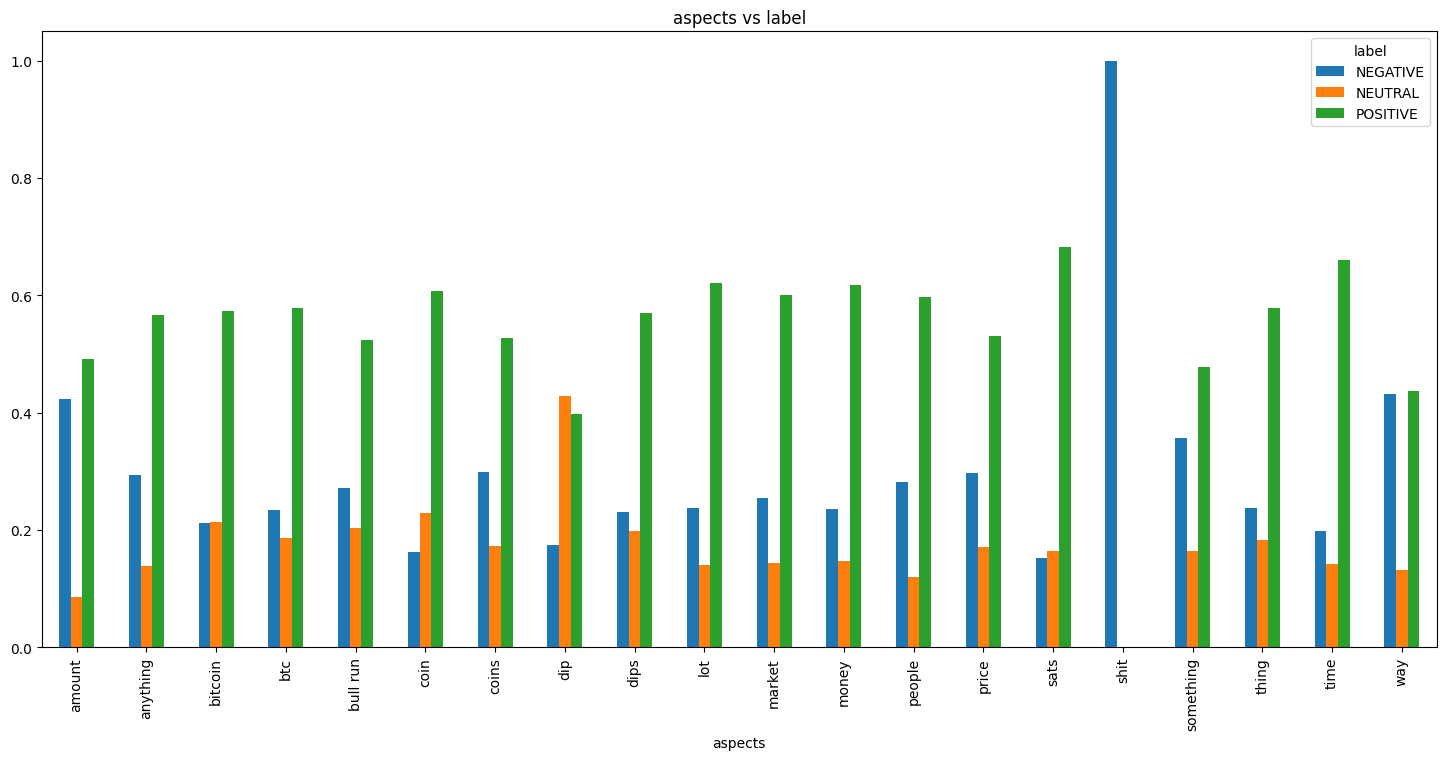

In [ ]:
Analyst(dftem, "aspects","label")

Nhìn chung từ năm 2019 tới năm 2022, mọi người đều có ý kiến tích cực với các khía cạnh của BigCoin.

### Câu hỏi nghiên cứu 5: Thái độ của nhà đầu tư về Bigcoin với khía cạnh elon musk theo thời gian. Nó có ảnh hưởng tới giá không?

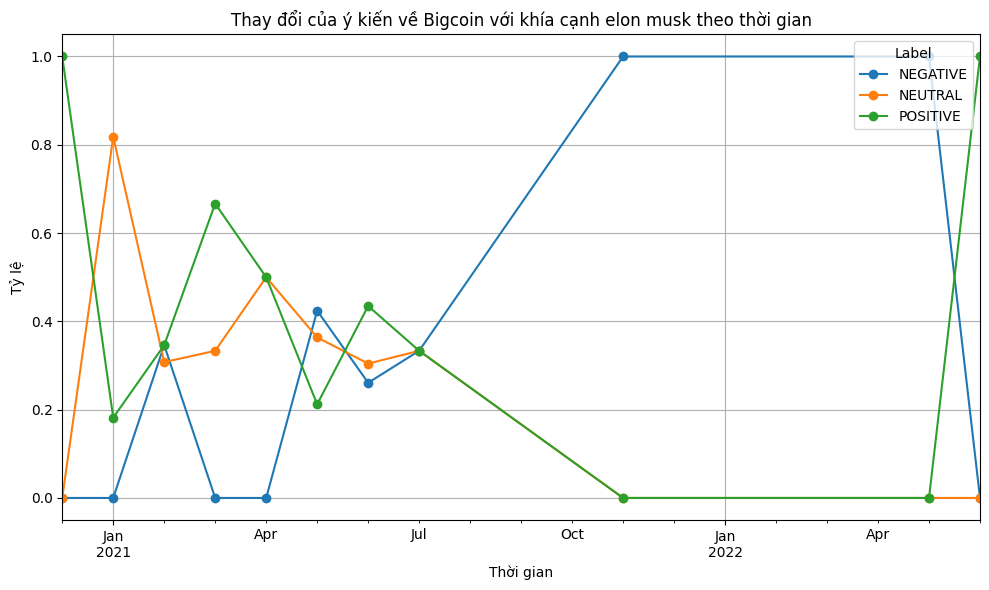

In [ ]:
kc = "elon musk"
df_tem =  df2[df2["aspects"].str.lower() ==kc]
# Tính tỷ lệ các nhãn 'label' theo từng tháng
label_counts = df_tem.groupby('year_month')['label'].value_counts(normalize=True).unstack().fillna(0)

# Biểu đồ line chart hiển thị thay đổi của các nhãn 'label' qua thời gian
label_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Thay đổi của ý kiến về Bigcoin với khía cạnh ' + kc+ ' theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Tỷ lệ')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

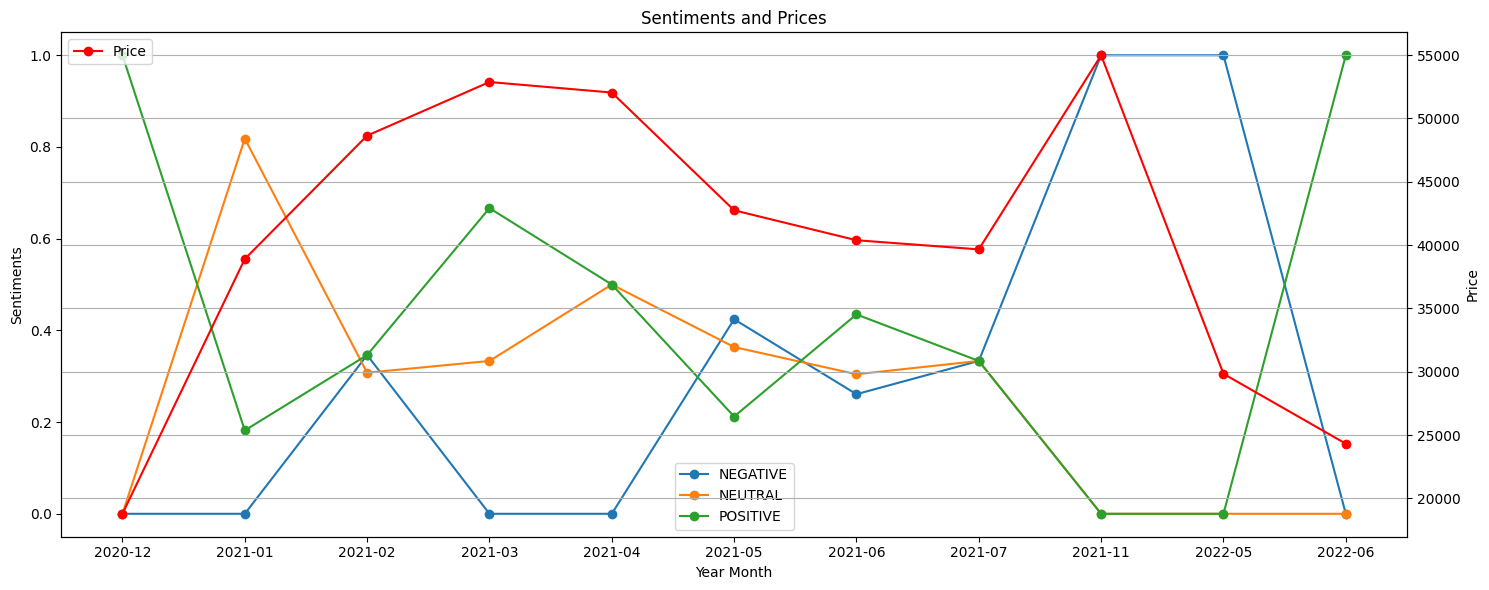

In [ ]:
kc = "elon musk"
df2_aspect =  df2[df2["aspects"].str.lower() ==kc]
# Tính giá trị trung bình của cột "Lần cuối" theo từng year_month trong df3
df3_mean2  = df3.groupby(["year_month"])["Lần cuối"].mean().reset_index()
# Tính tỷ lệ các nhãn 'label' theo từng tháng
df2_label_counts2 = df2_aspect.groupby('year_month')['label'].value_counts(normalize=True).unstack().fillna(0)
# Ghép DataFrame theo cột thời gian
merged_df2 = pd.merge(df3_mean2, df2_label_counts2, left_on='year_month', right_on='year_month', how='inner')
Analyst_1x_2y(merged_df2, ["NEGATIVE","NEUTRAL","POSITIVE"], ['Lần cuối'], (15, 6))

Thái độ của mọi người về BigCoin theo khía cạnh elon musk có mỗi liên hệ giữa biến động giá BigCoin:
Thường khi % tiêu cực về khía canh Elon Musk tăng thì giá bitcoin cũng bắt đầu giảm mạnh.


Dưới đây là một số tóm tắt lịch sử về mối quan hệ giữa Elon Musk và Bitcoin: Elon Musk là một trong những tỷ phú công nghệ nổi tiếng nhất thế giới, đồng thời cũng là một người có sức ảnh hưởng lớn đến thị trường tiền điện tử. Các tuyên bố và hành động của Musk thường gây ra những biến động mạnh mẽ trên thị trường này.

Tháng 1 năm 2021	Tesla bắt đầu chấp nhận Bitcoin làm phương thức thanh toán.

Tháng 2 năm 2021	Musk tweet rằng Tesla đã mua 1,5 tỷ đô la Bitcoin.

Tháng 3 năm 2021	Giá Bitcoin đạt mức cao kỷ lục 64.870 đô la.

Tháng 4 năm 2021	Musk nói rằng Tesla có thể ngừng chấp nhận Bitcoin nếu tỷ lệ khai thác Bitcoin không trở nên bền vững hơn.

Tháng 5 năm 2021	Musk tweet rằng Tesla đã ngừng chấp nhận Bitcoin làm phương thức thanh toán.

Tháng 6 năm 2021	Musk gọi Bitcoin là "sự lừa đảo" trong một cuộc phỏng vấn.

Tháng 7 năm 2021	Musk nói rằng ông đã bán tất cả Bitcoin của mình.

Tháng 8 năm 2021	Musk tweet rằng ông vẫn tin tưởng vào tiền điện tử, nhưng ông không chắc chắn về Bitcoin.

Tháng 9 năm 2021	Musk tweet rằng ông tin rằng Dogecoin có thể trở thành tiền tệ toàn cầu.

Tháng 10 năm 2021	Musk tweet rằng ông đang "bật lại" Bitcoin.

Tháng 11 năm 2021	Musk nói rằng ông tin rằng Bitcoin có thể trở thành "sự lựa chọn tiền tệ của tương lai".

Tháng 12 năm 2021	Musk tweet rằng ông đang cân nhắc việc sử dụng Bitcoin để thanh toán cho các sản phẩm và dịch vụ của Tesla.

Tháng 1 năm 2022	Musk tweet rằng ông vẫn tin tưởng vào Bitcoin và sẽ tiếp tục ủng hộ nó.

Tháng 2 năm 2022	Musk nói rằng ông tin rằng Bitcoin có thể trở thành "cơ sở hạ tầng tài chính của tương lai".

Tháng 3 năm 2022	Musk tweet rằng ông tin rằng Bitcoin có thể trở thành "cơ sở hạ tầng tài chính của tương lai".

Tháng 4 năm 2022	Musk tweet rằng ông tin rằng Bitcoin có thể trở thành "cơ sở hạ tầng tài chính của tương lai".

Tháng 5 năm 2022	Musk tweet rằng ông vẫn tin tưởng vào Bitcoin và sẽ tiếp tục ủng hộ nó.

Tháng 6 năm 2022	Musk nói trong một cuộc phỏng vấn rằng ông tin rằng Bitcoin có thể trở thành tiền tệ toàn cầu trong tương lai.

Tháng 7 năm 2022	Tesla mua lại 75 BTC, trị giá khoảng 25 triệu đô la.

## **Câu hỏi nghiên cứu số 6**

## Xây dựng mô hình học sâu

In [ ]:
!pip install keras.utils

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPool1D, Flatten, concatenate, Dense, \
    LSTM, Bidirectional, Activation, MaxPooling1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, \
    TimeDistributed, Permute, multiply, Lambda, add, Masking, BatchNormalization, Softmax, Reshape, ReLU, \
    ZeroPadding1D, subtract
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import keras.backend as K
import tensorflow as tf
from keras import backend as K, initializers, regularizers, constraints


# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from tensorflow.keras.layers import Layer, InputSpec
import numpy as np

from statistics import mode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline
import tensorflow as tf

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
import tensorflow_hub as hub



import re
import nltk
from nltk.corpus import stopwords

# neural
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

#Metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DeepLearning/dataset/dataset50k_have_label.csv")
df.head()

,comment,aspects,label,aspects_position,created_time
0,if this goes any lower my dad is going to give...,belt,NEUTRAL,13.0,1.621424e+09
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,POSITIVE,5.5,1.621430e+09
2,guys I am a long time bitcoiner from . not ric...,lot,POSITIVE,15.0,1.621430e+09
3,guys I am a long time bitcoiner from . not ric...,money,POSITIVE,49.0,1.621430e+09
4,this place is like a time capsule. I remember ...,time capsule,POSITIVE,5.5,1.621413e+09


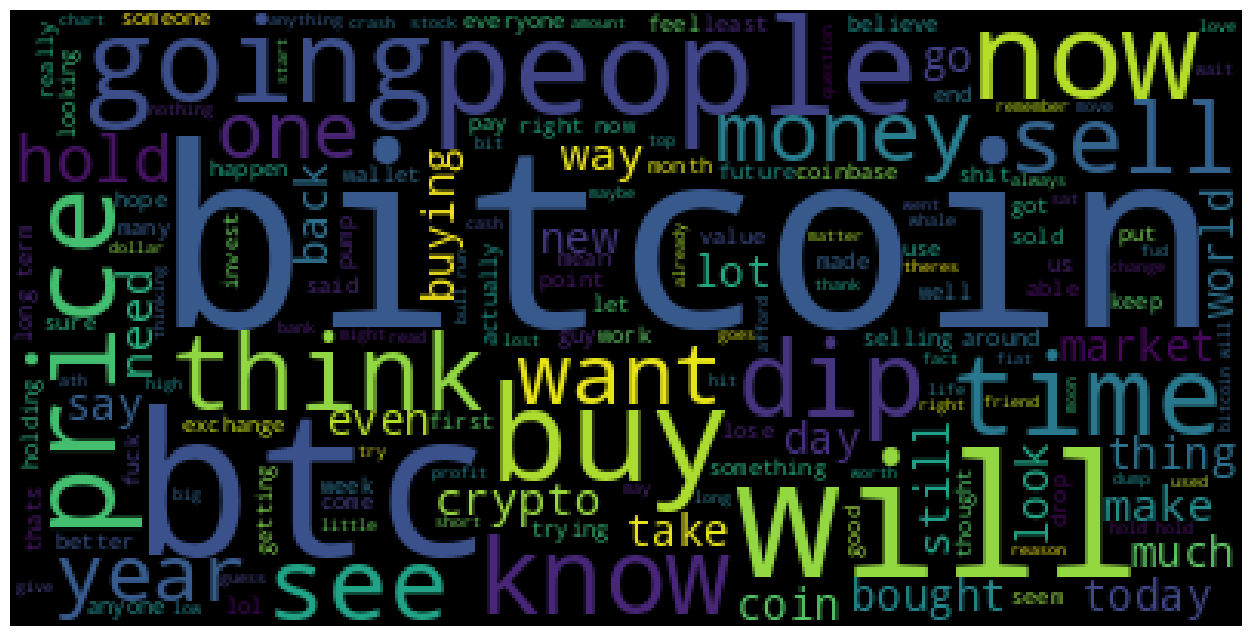

In [ ]:
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(' '.join(df['comment'])),
text3 = ' '.join(df['comment'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [ ]:
## đếm giá trị na trong cột label
df['label'].isna().sum()

0

In [ ]:
## thay đổi nhãn thành số nguyên cho giai đoạn huấn luyện
df['label'][df["label"] == 'NEGATIVE'] = 0
df['label'][df["label"] == 'POSITIVE'] = 1
df['label'][df["label"] == 'NEUTRAL'] = 2

<ipython-input-51-bd08cac7ff3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][df["label"] == 'NEGATIVE'] = 0
<ipython-input-51-bd08cac7ff3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][df["label"] == 'POSITIVE'] = 1
<ipython-input-51-bd08cac7ff3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][df["label"] == 'NEUTRAL'] = 2


In [ ]:
df.head()

,comment,aspects,label,aspects_position,created_time
0,if this goes any lower my dad is going to give...,belt,2,13.0,1.621424e+09
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,1,5.5,1.621430e+09
2,guys I am a long time bitcoiner from . not ric...,lot,1,15.0,1.621430e+09
3,guys I am a long time bitcoiner from . not ric...,money,1,49.0,1.621430e+09
4,this place is like a time capsule. I remember ...,time capsule,1,5.5,1.621413e+09


In [ ]:
train_df = df.loc[:, ['comment','aspects','label']]
train_df.head()

,comment,aspects,label
0,if this goes any lower my dad is going to give...,belt,2
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner,1
2,guys I am a long time bitcoiner from . not ric...,lot,1
3,guys I am a long time bitcoiner from . not ric...,money,1
4,this place is like a time capsule. I remember ...,time capsule,1


In [ ]:
## Chuyển đổi label thành số nguyên, nếu không phải số nguyên thì chuyển về dạng NaN
train_df["label"] = pd.to_numeric(train_df["label"],errors='coerce')

In [ ]:
print(train_df['label'].unique())
print(train_df.shape)

[2 1 0]
(60716, 3)


<Axes: >

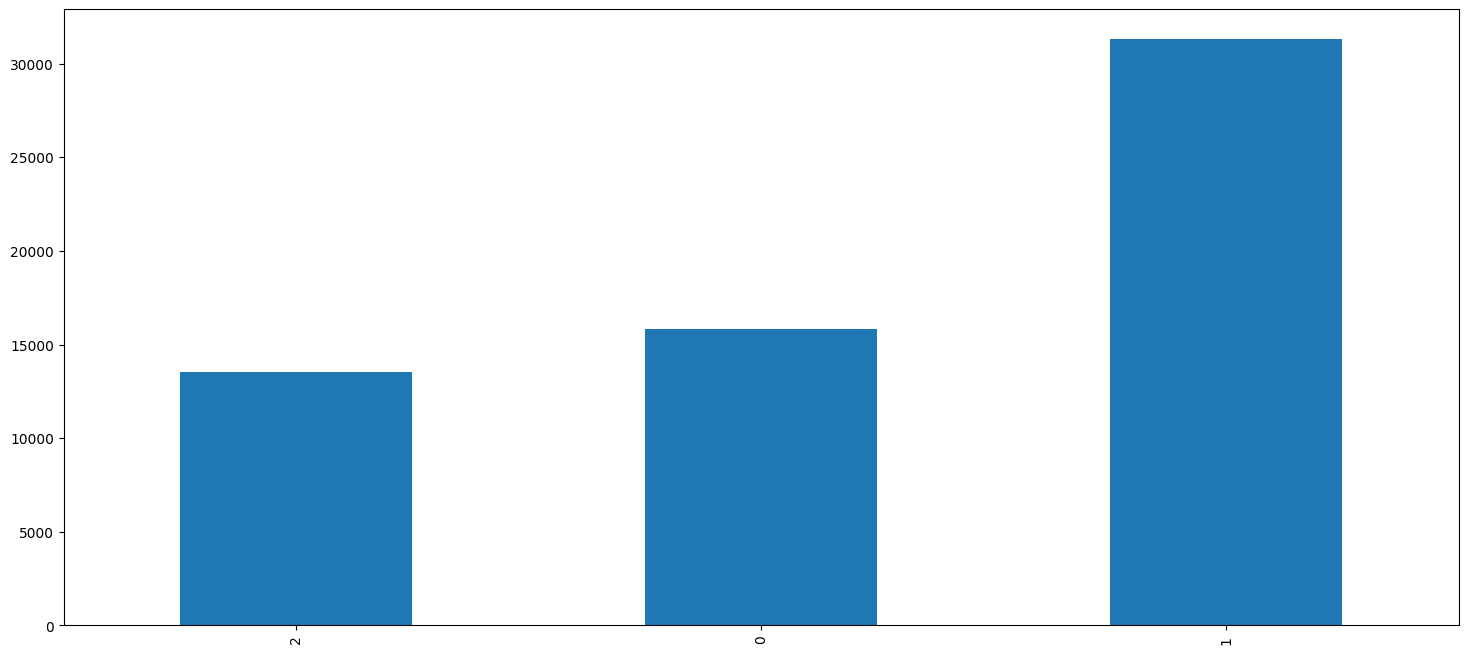

In [ ]:
train_df.label.value_counts().sort_values().plot(kind = 'bar')

In [ ]:
## Verify if the dataframe contains any NAN Values
train_df.isna().sum()

comment    0
aspects    0
label      0
dtype: int64

In [ ]:
train_df.loc[:, ['comment','aspects']]

,comment,aspects
0,if this goes any lower my dad is going to give...,belt
1,guys I am a long time bitcoiner from . not ric...,time bitcoiner
2,guys I am a long time bitcoiner from . not ric...,lot
3,guys I am a long time bitcoiner from . not ric...,money
4,this place is like a time capsule. I remember ...,time capsule
...,...,...
60711,not not much new money left. any retail ie hol...,bots
60712,not not much new money left. any retail ie hol...,public
60713,not not much new money left. any retail ie hol...,way bitcoin
60714,not not much new money left. any retail ie hol...,bitcoin


In [ ]:
## Chia tập dữ liệu thành tập dữ liệu huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(train_df.loc[:, ['comment','aspects']],train_df['label'],stratify=train_df['label'], test_size=0.2, random_state=1)

In [ ]:
X_train

,comment,aspects
24562,when your local takeout order is more expensiv...,bitcoin
19262,this is good. means we have not gone parabolic...,youll see
44654,key section of fed statement with inflation ru...,stance
10873,I am selling a kidney to buy during this dip. ...,kidney
44531,good work. built my dream bike too and now hav...,nothing
...,...,...
13256,"think about it, cash has lost lots of value in...",lots
10896,"bcash going hard with this, probably their las...",credit
28606,seems to be a lot of people fretting about pri...,downs
17401,that big swinging green donkey dick on the one...,hour candle


In [ ]:
y_train

24562    0
19262    1
44654    0
10873    2
44531    1
        ..
13256    2
10896    0
28606    0
17401    0
3456     1
Name: label, Length: 48572, dtype: int64

In [ ]:
NUM_WORDS = 100000
EMBEDDING_SIZE = 128

In [ ]:
#Tạo một Tokenizer để xử lý văn bản, giữ lại một số lượng từ tối đa (num_words).
#Loại bỏ các ký tự được chỉ định trong filters và có thể chuyển đổi tất cả các ký tự thành chữ thường (lower=True).
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True, )
## Cập nhật từ vựng nội bộ dựa trên danh sách comment.
tokenizer.fit_on_texts(list(X_train.comment))
#Chuyển đổi các đoạn văn bản trong X_train.comment thành các chuỗi số nguyên tương ứng
#với chỉ số của từng từ trong từ điển Tokenizer đã tạo từ dữ liệu huấn luyện trước đó.
text_X_train_tokenized = tokenizer.texts_to_sequences(X_train.comment) # list of tokenized sentences
Aspect_X_train_tokenized = tokenizer.texts_to_sequences(X_train['aspects']) # list of tokenized sentences
text_X_test_tokenized = tokenizer.texts_to_sequences(X_test.comment) # list of tokenized sentences
Aspect_X_test_tokenized = tokenizer.texts_to_sequences(X_test['aspects']) # list of tokenized sentences

In [ ]:
##Maximum length of sentences
Max_Len =  max([len(one_title) for one_title in text_X_train_tokenized])
Max_Len

782

In [ ]:
## Padding sequences
text_X_train_padded = pad_sequences(text_X_train_tokenized, maxlen=Max_Len)
aspect_X_train_padded = pad_sequences(Aspect_X_train_tokenized, maxlen=1)

text_X_test_padded = pad_sequences(text_X_test_tokenized, maxlen=Max_Len)
aspect_X_test_padded = pad_sequences(Aspect_X_test_tokenized, maxlen=1)

In [ ]:
## the embedding presentation of the aspects
aspect_X_train_padded[0]

array([11], dtype=int32)

In [ ]:
## the embedding presentation of the Sentences
text_X_train_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
## Concatenate the Embedding presentation of the sentences and aspects to Create training and testing dataset
train_data =  [text_X_train_padded,aspect_X_train_padded]
test_data =   [text_X_test_padded,aspect_X_test_padded]

In [ ]:
test_data[1][0]

array([2674], dtype=int32)

## **LSTM with Aspect Embedding**

In [ ]:
def ae_lstm(lstm_units = 512):
    # Định nghĩa đầu vào cho văn bản và phần aspect
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)
    # Tạo lớp embedding cho văn bản
    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))
    # Tạo lớp embedding cho phần aspect
    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    aspect_embed = asp_embedding(input_aspect)

    # Đưa aspect về dạng vector 2 chiều
    aspect_embed = Flatten()(aspect_embed)  # Định dạng lại thành ma trận 2 chiều
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # Lặp lại aspect cho mỗi từ trong chuỗi

    # Kết hợp văn bản và aspect
    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    # Xử lý LSTM cho dữ liệu kết hợp
    hidden = LSTM(lstm_units)(input_concat)
    Dense_layer  = Dense(128, activation='tanh')(hidden)
    output_layer = Dense(3, activation='softmax')(Dense_layer)
    return Model([input_text, input_aspect], output_layer)

In [ ]:
ae_lstm_model = ae_lstm()
ae_lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 782)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 128)               1280000   ['input_6[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_4 (Embedding)     (None, 782, 128)             1280000   ['input_5[0][0]']       

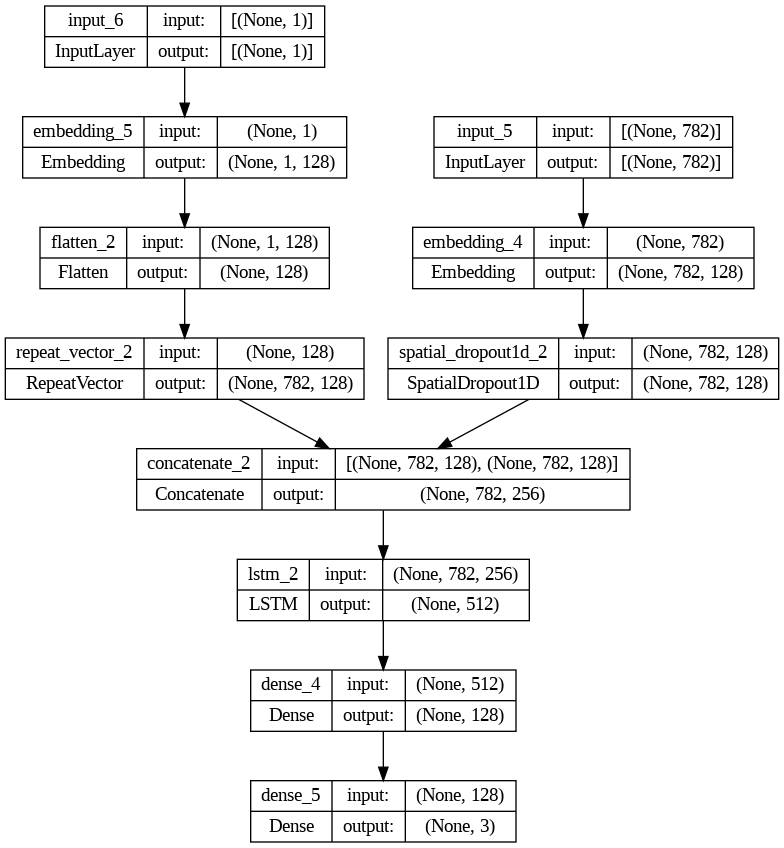

In [ ]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(ae_lstm_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
y_train.size

48572

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath=os.path.join('checkpoint_weights_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-8,
        patience=7,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        min_delta=1e-8,
        factor=0.1,
        patience=2,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
#ae_lstm_model.load_weights("checkpoint_weights_model.h5")

In [ ]:

from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.005)

ae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
history =  ae_lstm_model.fit(x = train_data, y = y_train,validation_data = (test_data, y_test), batch_size=32, epochs=5, callbacks = callbacks_list)

Epoch 1/5
1518/1518 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.7774
Epoch 1: val_accuracy improved from -inf to 0.88867, saving model to checkpoint_weights_model.h5
1518/1518 [==============================] - 235s 153ms/step - loss: 0.5277 - accuracy: 0.7774 - val_loss: 0.2623 - val_accuracy: 0.8887 - lr: 0.0050
Epoch 2/5
1518/1518 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.8958
Epoch 2: val_accuracy improved from 0.88867 to 0.90341, saving model to checkpoint_weights_model.h5
1518/1518 [==============================] - 205s 135ms/step - loss: 0.2406 - accuracy: 0.8958 - val_loss: 0.2335 - val_accuracy: 0.9034 - lr: 0.0050
Epoch 3/5
1518/1518 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9152
Epoch 3: val_accuracy did not improve from 0.90341
1518/1518 [==============================] - 204s 134ms/step - loss: 0.1996 - accuracy: 0.9152 - val_loss: 0.2249 - val_accuracy: 0.9033 - lr: 0.0050
Epoch 4/5
1

In [ ]:
ae_lstm_model.load_weights("checkpoint_weights_model.h5")

In [ ]:
text_X_test_padded[6].shape

(782,)

In [ ]:
val_data =   [text_X_test_padded[6].reshape(1,Max_Len),aspect_X_test_padded[6]]
print(val_data[0].shape)
ae_lstm_model.predict(val_data)

(1, 782)
1/1 [==============================] - 0s 444ms/step


array([[1.3234194e-01, 8.6740035e-01, 2.5769012e-04]], dtype=float32)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [ ]:
print("Evaluate on test data")
results = ae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
380/380 [==============================] - 17s 45ms/step - loss: 0.2335 - accuracy: 0.9034
test loss, test acc: [0.23351913690567017, 0.9034090638160706]
Accuracy of the model is -  90.34090638160706 %


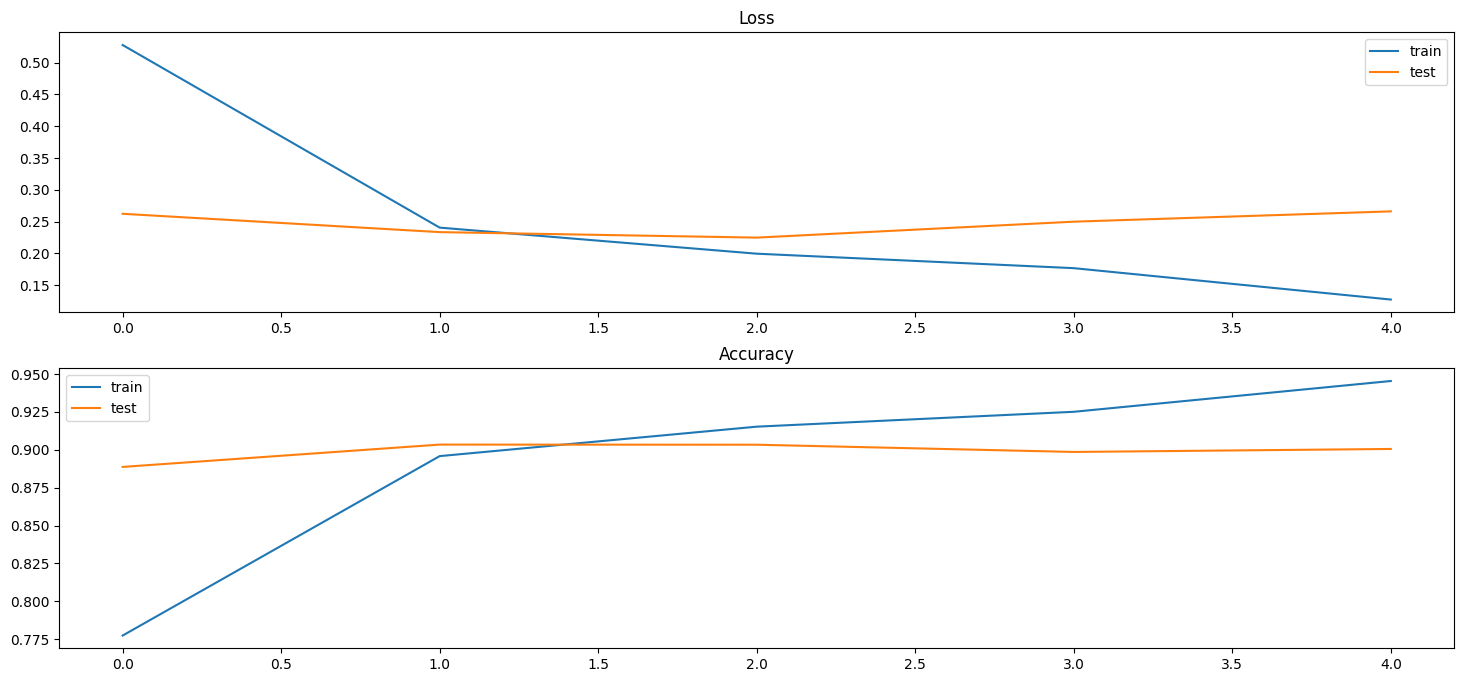

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


## Attention-based LSTM with Aspect Embedding (ATAE-LSTM)

In [ ]:

# modified based on `https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2`
class Attention(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
 e: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None, W_constraint=None,
                 u_constraint=None, b_constraint=None, use_W=True, use_bias=False, return_self_attend=False,
                 return_attend_weight=True, **kwargs):
        self.supports_masking = True

        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.use_W = use_W
        self.use_bias = use_bias
        self.return_self_attend = return_self_attend    # whether perform self attention and return it
        self.return_attend_weight = return_attend_weight    # whether return attention weight
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        if self.use_W:
            self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),  initializer=self.init,
                                     name='{}_W'.format(self.name), regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        if self.use_bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer, constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],), initializer=self.init, name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer, constraint=self.u_constraint)

        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        if self.use_W:
            x = K.tanh(K.dot(x, self.W))

        ait = Attention.dot_product(x, self.u)
        if self.use_bias:
            ait += self.b

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        if self.return_self_attend:
            attend_output = K.sum(x * K.expand_dims(a), axis=1)
            if self.return_attend_weight:
                return [attend_output, a]
            else:
                return attend_output
        else:
            return a

    def compute_output_shape(self, input_shape):
        if self.return_self_attend:
            if self.return_attend_weight:
                return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
            else:
                return input_shape[0], input_shape[-1]
        else:
            return input_shape[0], input_shape[1]

    @staticmethod
    def dot_product(x, kernel):
        """
        Wrapper for dot product operation, in order to be compatible with both
        Theano and Tensorflow
        Args:
            x (): input
            kernel (): weights
        Returns:
        """
        if K.backend() == 'tensorflow':
            return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
        else:
            return K.dot(x, kernel)

In [ ]:
# attention-based lstm with aspect embedding
def atae_lstm(lstm_units = 128):
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)

    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))

    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)

    aspect_embed = asp_embedding(input_aspect)
    aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence

    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    print(input_concat.shape)
    # Sử dụng LSTM để xử lý đầu vào và trả về các chuỗi ẩn (hidden_vecs) và trạng thái cuối cùng (state_h)
    hidden_vecs, state_h, _ = LSTM(lstm_units, return_sequences=True, return_state=True, activation='tanh')(input_concat)
    # Nối (concatenate) hidden_vecs và repeat_aspect theo chiều cuối cùng (axis=-1)
    concat = concatenate([hidden_vecs, repeat_aspect], axis=-1)

    # Áp dụng cơ chế chú ý
    attend_weight = Attention()(concat)
    attend_weight_expand = Lambda(lambda x: K.expand_dims(x))(attend_weight) # Tính toán trọng số chú ý
    attend_hidden = multiply([hidden_vecs, attend_weight_expand])# Nhân hidden_vecs với trọng số chú ý mở rộng
    attend_hidden = Lambda(lambda x: K.sum(x, axis=1))(attend_hidden) # Tính tổng theo chiều 1 để thu được hidden vectors chú ý

    # Xử lý hidden vectors đã chú ý và trạng thái ẩn cuối cùng thông qua các lớp Dense
    attend_hidden_dense = Dense(lstm_units, activation='tanh')(attend_hidden)# Lớp Dense cho hidden vectors chú ý
    last_hidden_dense = Dense(lstm_units, activation='tanh')(state_h)# Lớp Dense cho trạng thái ẩn cuối cùng
    final_output = Activation('softmax')(add([attend_hidden_dense, last_hidden_dense]))# Kết hợp và áp dụng hàm kích hoạt tanh cho kết quả cuối cùng

    return Model([input_text, input_aspect], final_output)

In [ ]:
atae_lstm_model =  atae_lstm()
atae_lstm_model.summary()

(None, 782, 256)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 782)]                0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 1, 128)               1280000   ['input_12[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_10 (Embedding)    (None, 782, 128)             1280000   ['input

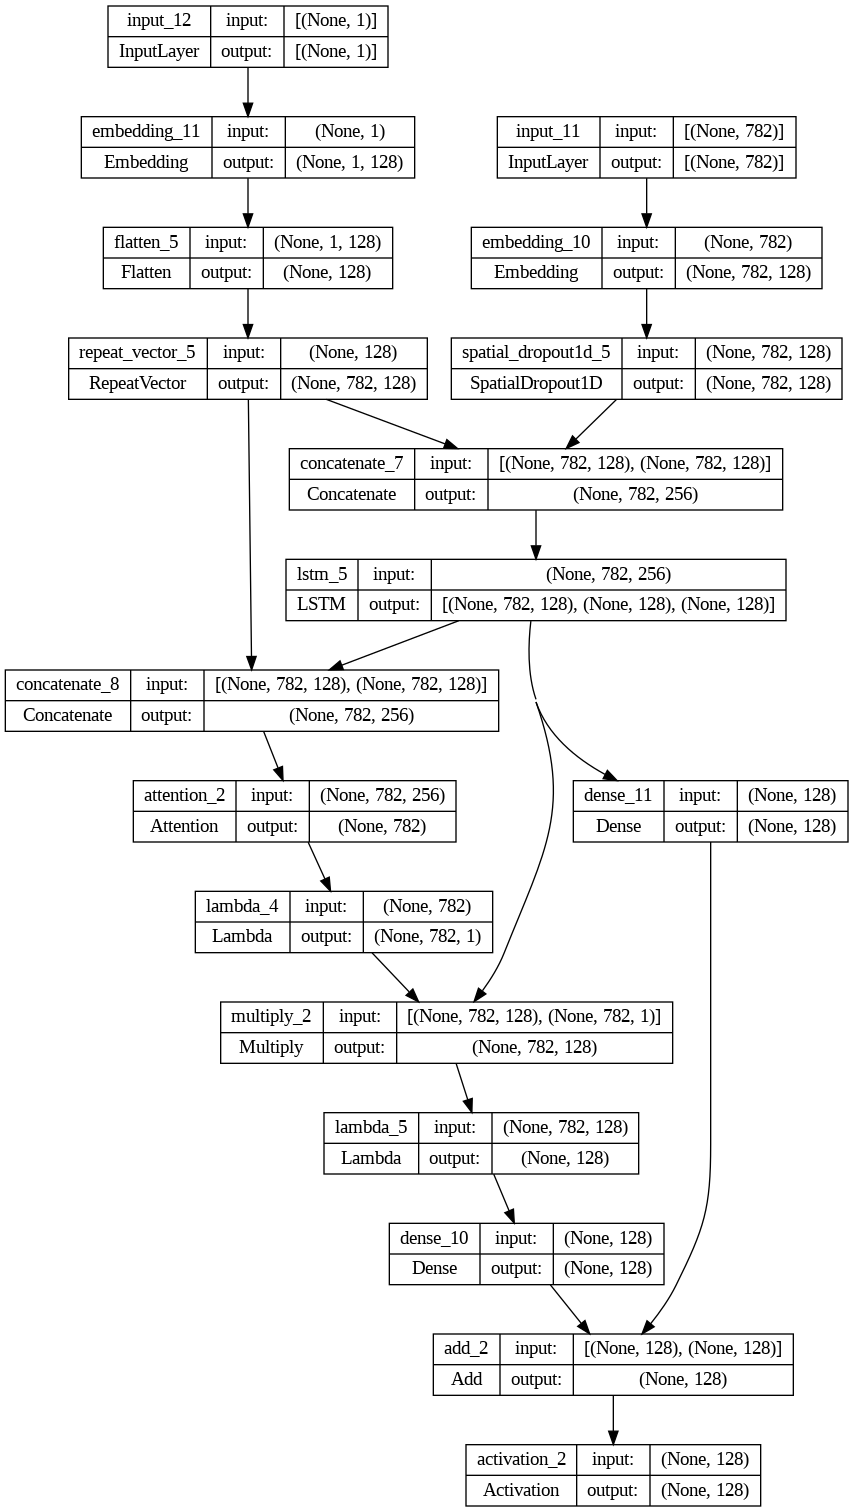

In [ ]:
dot_img_file = 'model_2.png'
tf.keras.utils.plot_model(atae_lstm_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath=os.path.join('checkpoint_weights_model_2.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-8,
        patience=7,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        min_delta=1e-8,
        factor=0.5,
        patience=2,
        verbose=1)
]
callbacks_list2 = callbacks

In [ ]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00001)

atae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
history2 = atae_lstm_model.fit(x = train_data, y = y_train,validation_data = (test_data, y_test), batch_size=32, epochs=3, callbacks = callbacks_list2)

Epoch 1/3
1518/1518 [==============================] - ETA: 0s - loss: 2.7861 - accuracy: 0.3942
Epoch 1: val_accuracy improved from -inf to 0.51614, saving model to checkpoint_weights_model_2.h5
1518/1518 [==============================] - 119s 76ms/step - loss: 2.7861 - accuracy: 0.3942 - val_loss: 1.7979 - val_accuracy: 0.5161 - lr: 1.0000e-05
Epoch 2/3
1518/1518 [==============================] - ETA: 0s - loss: 1.7292 - accuracy: 0.5161
Epoch 2: val_accuracy did not improve from 0.51614
1518/1518 [==============================] - 73s 48ms/step - loss: 1.7292 - accuracy: 0.5161 - val_loss: 1.6950 - val_accuracy: 0.5161 - lr: 1.0000e-05
Epoch 3/3
1517/1518 [============================>.] - ETA: 0s - loss: 1.6837 - accuracy: 0.5161
Epoch 3: val_accuracy did not improve from 0.51614

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1518/1518 [==============================] - 69s 46ms/step - loss: 1.6837 - accuracy: 0.5161 - val_loss: 1.6762 - val_accuracy

In [ ]:
print("Evaluate on test data")
results = atae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
380/380 [==============================] - 6s 15ms/step - loss: 1.6762 - accuracy: 0.5161
test loss, test acc: [1.6761834621429443, 0.5161396861076355]
Accuracy of the model is -  51.61396861076355 %


Nhóm em đã tập trung vào mô hình LSTM.

Mô hình phân loại tình cảm với LSTM đạt được 90% độ chính xác là một kết quả ấn tượng, cho thấy mô hình có khả năng tốt trong việc nhận diện và phân loại cảm xúc theo khía cạnh từ dữ liệu đầu vào. Điều này cho thấy mô hình có khả năng học và áp dụng các mẫu dữ liệu một cách hiệu quả để đưa ra dự đoán chính xác.

Tuy nhiên, vấn đề với mô hình attention khó training và chỉ đạt được 50% độ chính xác có thể là một điểm đáng chú ý. Attention trong mô hình có thể cải thiện khả năng tập trung vào các đặc trưng quan trọng của dữ liệu đầu vào, nhưng việc huấn luyện mô hình này có thể đòi hỏi nhiều thời gian và kỹ thuật hơn để đạt được kết quả tốt.

Để cải thiện mô hình, có thể cần xem xét việc tối ưu hóa việc huấn luyện mô hình attention hoặc thử nghiệm với các phương pháp khác để cải thiện khả năng phân loại. Việc phân tích kỹ thuật cũng như tập trung vào việc cải thiện mô hình attention sẽ có thể giúp tăng cường khả năng dự đoán chính xác của mô hình trong tương lai.